In [24]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists

In [25]:
def videoReader(video, play=False):
    cap = cv2.VideoCapture(video)
    if (cap.isOpened() == False):
        print("Error opening video stream or file")
    if play:
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == True:
                cv2.imshow('Frame', frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            else:
                break
        cap.release()
        cv2.destroyAllWindows()
    return cap

In [26]:
IMG_PATH = "../data/images/beach.jpeg"
VIDEO_PATH = "../data/videos/data/videos_h264/Time_Lapse_Sunset_Over_the_Lake___Canon_5D_Mark_II.mp4"

TIMESTAMPS = [60*1000, 75*1000, 78*1000]
# 0 - Golden Hour 1 - Blue Hour 2 - Night

In [27]:
def get_mean_and_std(x):
	x_mean, x_std = cv2.meanStdDev(x)
	x_mean = np.hstack(np.around(x_mean,2))
	x_std = np.hstack(np.around(x_std,2))
	return x_mean, x_std

In [28]:
def imageHistogram(image):
    nbins = 256
    hist_b = cv2.calcHist([image], [0], None, [nbins], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [nbins], [0, 256])
    hist_r = cv2.calcHist([image], [2], None, [nbins], [0, 256])

    hist_des = np.vstack((hist_r, hist_g, hist_b)).ravel()
    hist_des = hist_des/image.size
    return hist_des

def saveImageHistogram(video_path, sample_frames=100, dir="../data/histograms/"):
    cap = videoReader(video_path)
    numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    samplingRate = max(1, numberOfFrames//sample_frames)

    idx = []
    frame_descriptors = []

    for i in range(0, numberOfFrames, samplingRate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        res, frame = cap.read()
        # save only the top half of the image
        frame = frame[:frame.shape[0]//2, :, :]
        idx.append(i)
        frame_descriptors.append(imageHistogram(frame))

    idx = np.array(idx)
    frame_descriptors = np.array(frame_descriptors)
    with open(join(dir, video_path.split("/")[-1].split(".")[0] + ".pickle"), 'wb') as f:
        pickle.dump({'idx': idx, 'descriptors': frame_descriptors},
                    f, protocol=pickle.HIGHEST_PROTOCOL)
        
def loadImageHistogram(video_path, sample_frames=100, dir="../data/histograms/"):
    filename = join(dir, video_path.split(
        "/")[-1].split(".")[0] + ".pickle")
    if not exists(filename):
        saveImageHistogram(video_path, sample_frames, dir)

    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def bestFrame(image, video_path, sample_frames=100):
        '''Search for best frame given a particular video'''
        image_descriptor = imageHistogram(image).reshape((1, -1))

        cap = videoReader(video_path)
        numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        samplingRate = max(1, numberOfFrames//sample_frames)

        frame_descriptors = loadImageHistogram(video_path, sample_frames)

        #compute the distance between the image descriptor and the frame descriptors
        dist = np.linalg.norm(image_descriptor - frame_descriptors['descriptors'], axis=1)

        #find the index of the frame with the minimum distance
        best_frame_idx = frame_descriptors['idx'][np.argmin(dist)]

        #set the video to the best frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)

        #read the frame
        res, frame = cap.read()
        return frame

In [29]:
def color_transfer(IMG_PATH, VIDEO_PATH, TIMESTAMPS, TIME=1):
    
    if TIME>2 or TIME<0:
        print("TIME must be 0, 1 or 2")
        return
    
    #read the image
    s = cv2.imread(IMG_PATH)
    
    #read the video
    cap = videoReader(VIDEO_PATH)
    timestamp = TIMESTAMPS[TIME]
    cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
    res, t = cap.read()

    best_frame = bestFrame(s, VIDEO_PATH)

    #convert the images to LAB color space
    s_og = s
    s = cv2.cvtColor(s,cv2.COLOR_BGR2LAB)
    t = cv2.cvtColor(t,cv2.COLOR_BGR2LAB)
    
    #convert the images to the same size
    s = cv2.resize(s,(t.shape[1],t.shape[0]))

    s_mean, s_std = get_mean_and_std(s)
    t_mean, t_std = get_mean_and_std(t)

    height, width, channel = s.shape
    for i in range(0,height):
        for j in range(0,width):
            for k in range(0,channel):
                x = s[i,j,k]
                x = ((x-s_mean[k])*(t_std[k]/s_std[k]))+t_mean[k]
                # round or +0.5
                x = round(x)
                # boundary check
                x = 0 if x<0 else x
                x = 255 if x>255 else x
                s[i,j,k] = x

    s = cv2.cvtColor(s,cv2.COLOR_LAB2BGR)
    cv2.imwrite('../data/output/match/beach_canon5d_1_15_color_transfer.jpg', s)
    
    #plot image, best frame, target frame and the color transfered image
    fig, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].imshow(cv2.cvtColor(s_og, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[1].imshow(cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Best Frame')
    ax[2].imshow(cv2.cvtColor(t, cv2.COLOR_LAB2RGB))
    ax[2].set_title('Target Frame')
    ax[3].imshow(cv2.cvtColor(s, cv2.COLOR_BGR2RGB))
    if TIME == 0:
        ax[3].set_title('Golden Hour')
    elif TIME == 1:
        ax[3].set_title('Blue Hour')
    elif TIME == 2:
        ax[3].set_title('Night')

    plt.show()
    
    return s

In [30]:
saveImageHistogram(VIDEO_PATH)

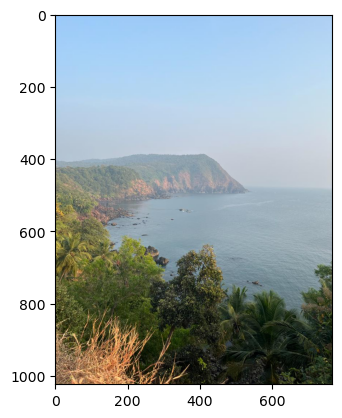

In [31]:
image = cv2.imread(IMG_PATH)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

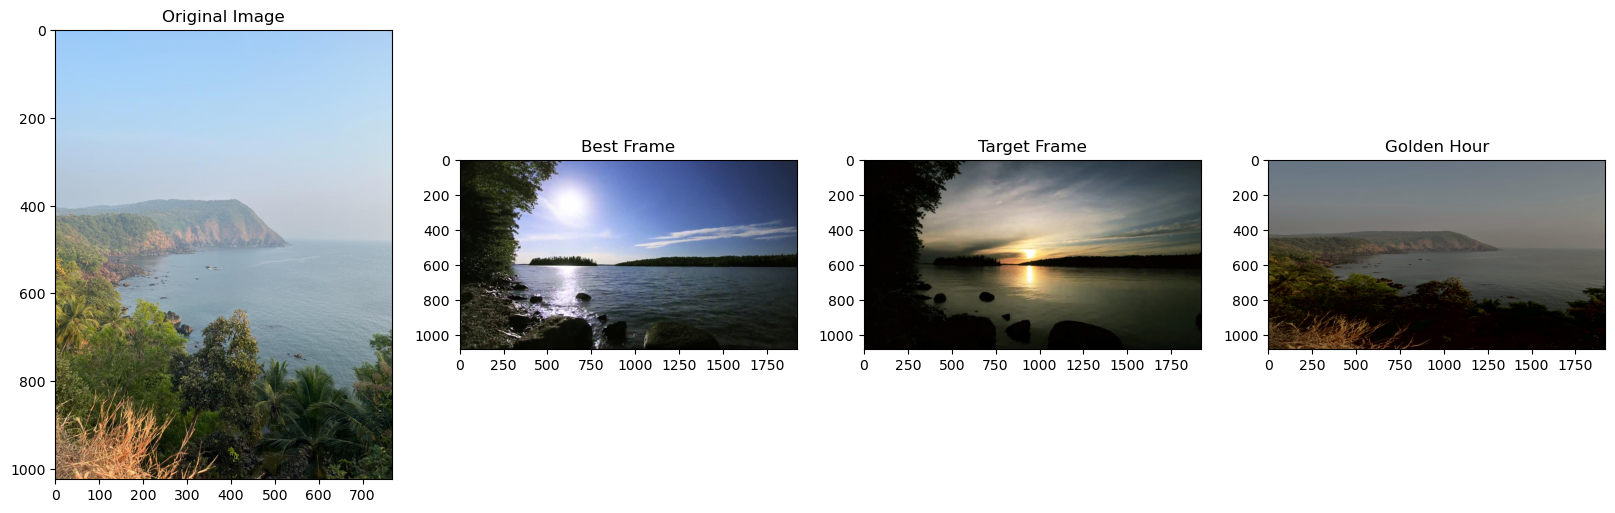

In [32]:
ct = color_transfer(IMG_PATH, VIDEO_PATH, TIMESTAMPS, TIME=0)

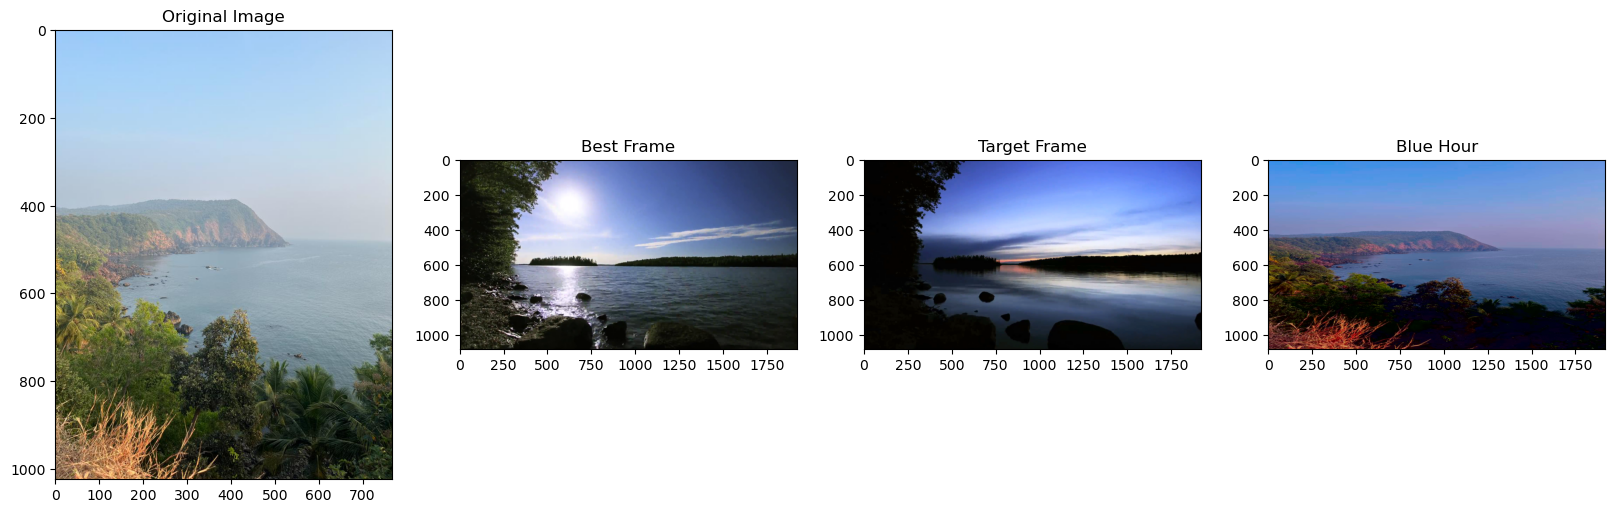

In [33]:
ct = color_transfer(IMG_PATH, VIDEO_PATH, TIMESTAMPS, TIME=1)

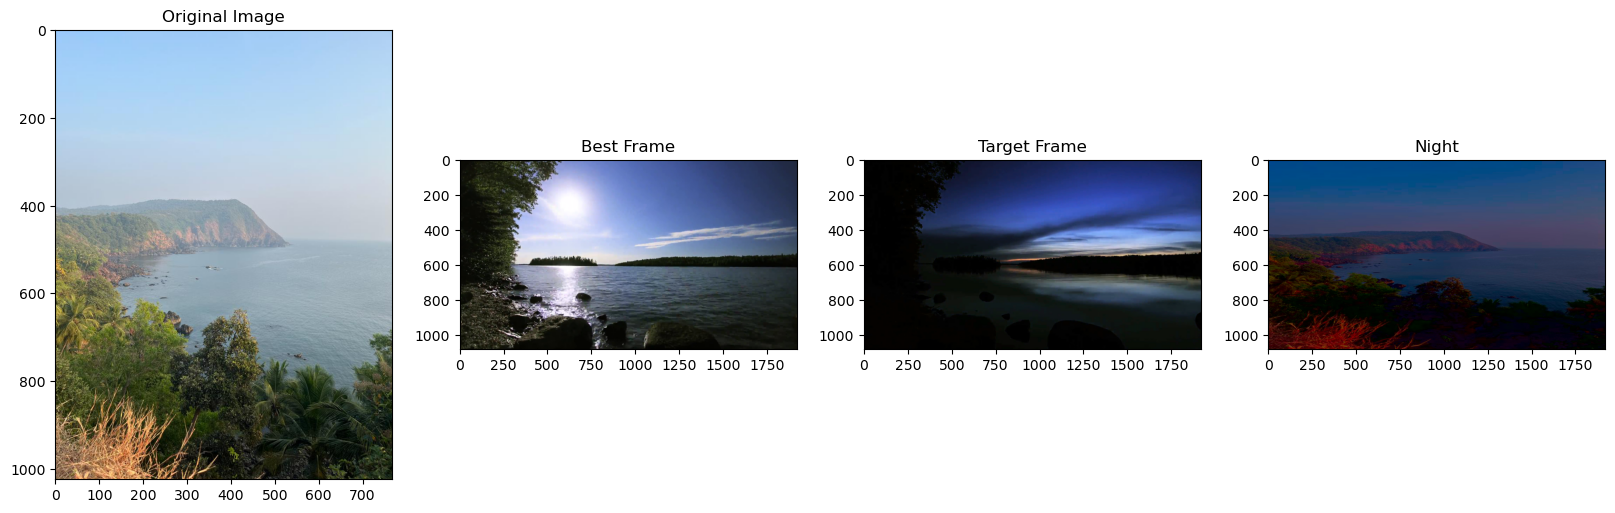

In [34]:
ct = color_transfer(IMG_PATH, VIDEO_PATH, TIMESTAMPS, TIME=2)